# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

/Users/minomichiang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter
from collections import defaultdict
import csv

Populating the interactive namespace from numpy and matplotlib


/Users/minomichiang/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


First of all, you have you have to read the data. Run the cell below to unpack data.

In [ ]:
#from get_data import unpack
#unpack('Face_Recognition_data.zip')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [8]:
def get_image_data(dir_name, filetype):
    x_data = defaultdict(np.array)
    y_data = defaultdict(std)
    
    y_raw = csv.reader(open(os.path.join(dir_name, filetype+'.csv'), newline=''))
    dirname = os.path.join(dir_name, 'images')
    for row in y_raw:
        if row[0].find('jpg') > 0 and len(row) >= 2:
            image = imread(os.path.join(dirname, row[0]))
            if len(image.shape) == 2: # image is gray
                image = color.gray2rgb(image)
            x_data[row[0]] = image[:, :, :3]
            y_data[row[0]] = row[1] 
    return x_data, y_data

In [9]:
def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    x_train, y_train = get_image_data(os.path.join(dir_name, 'train'), 'y_train')
    x_test, y_test   = get_image_data(os.path.join(dir_name, 'test'), 'y_test')
    return x_train, y_train, x_test, y_test

In [10]:
x_train, y_train, x_test, y_test = load_image_data()
print('%d'%len(x_train), '\ttraining images')
print('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [13]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

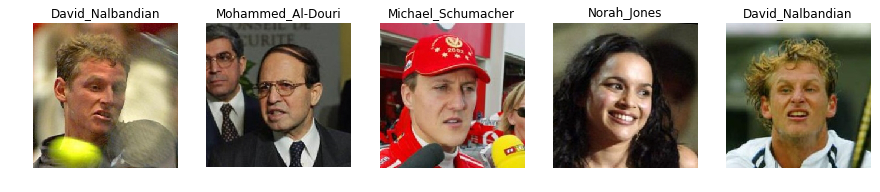

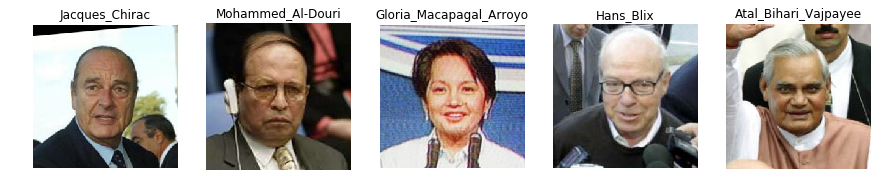

In [14]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [15]:
def get_video_data(dir_name, filetype):
    x_data = defaultdict(list)
    y_data = defaultdict(list)
    
    y_raw = csv.reader(open(os.path.join(dir_name, filetype+'.csv'), newline=''))
    dirname = os.path.join(dir_name, 'videos') #delta_w//2, delta_h//2, 
    dirfiles = os.listdir(dirname)
    
    for row in y_raw:
        if row[0] in dirfiles and len(row) >= 2:
            imagesfile = os.path.join(dirname, row[0])
            imagesnames = os.listdir(imagesfile)
            for picname in imagesnames:
                image = imread(os.path.join(imagesfile, picname))
                if len(image.shape) == 2: # image is gray
                    image = color.gray2rgb(image)
                x_data[row[0]].append(image[:, :, :3])
            y_data[row[0]] = row[1]
    return x_data, y_data

In [16]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    """Your implementation"""
    x_train, y_train = get_image_data(os.path.join(dir_name, 'train'), 'y_train')
    video_test, test_labels = get_video_data(os.path.join(dir_name, 'test'), 'y_test')
    return x_train, y_train, video_test, test_labels

In [29]:
video_train, train_labels, video_test, test_labels = load_video_data()
print('%d'%len(video_train), '\ttraining images')
print('%d'%len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


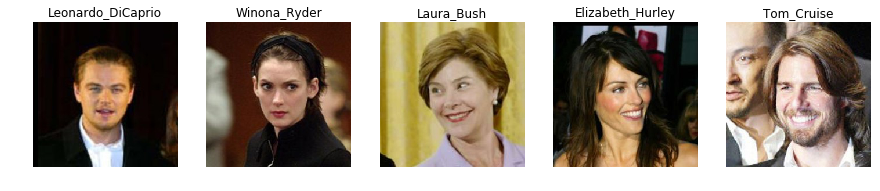

In [81]:
visualize(video_train, train_labels)

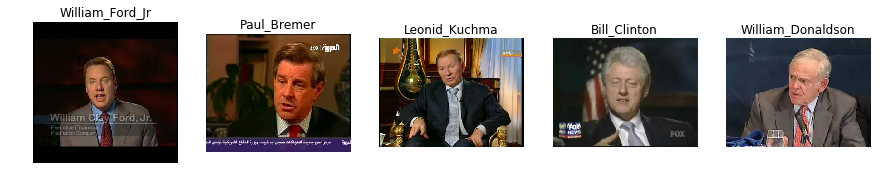

In [82]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [18]:
import cv2, math

def images_list_to_padded_array(imgs):
    # Find maximums for spatial dimension of images
    max_h = 0
    max_w = 0
    for img in imgs:
        if img.shape[0] > max_h:
            max_h = img.shape[0]
        if img.shape[1] > max_w:
            max_w = img.shape[1]
    
    # Create numpy array and position images in top left corner
    imgs_arr = np.zeros((len(imgs), max_h, max_w, 3), dtype=np.uint8)
    for idx, img in enumerate(imgs):
        imgs_arr[idx, :img.shape[0], :img.shape[1], :] = img
    
    # Print info and return images
#     print('Images are of shape: ' + str(imgs_arr[0].shape))
    return imgs_arr

def align_cropps(cropps):
    eye_cascade = cv2.CascadeClassifier('/Users/minomichiang/anaconda3/pkgs/opencv-3.3.1-py36h60a5f38_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
    faces = np.zeros(cropps.shape, dtype=np.float32)
    for idx, crop in enumerate(cropps):
        eyes_list = eye_cascade.detectMultiScale(cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY))
        if len(eyes_list) > 1:
            eyes = np.array(eyes_list, dtype=np.int32)
            left_eye_cand = eyes[eyes[:, 0] < 224/2]
            right_eye_cand = eyes[eyes[:, 0] >= 224/2]
            if left_eye_cand.shape[0] == 0 or right_eye_cand.shape[0] == 0:
                faces[idx] = crop.astype(np.float32) / 255.
                continue

            left_eye = left_eye_cand[0]
            for eye in left_eye_cand:
                if eye[2]*eye[3] > left_eye[2]*left_eye[3]:
                    left_eye = eye

            right_eye = right_eye_cand[0]
            for eye in right_eye_cand:
                if eye[2]*eye[3] > right_eye[2]*right_eye[3]:
                    right_eye = eye

            right_eye_cent = (right_eye[0]+right_eye[2]//2, right_eye[1]+right_eye[3]//2)
            left_eye_cent = (left_eye[0]+left_eye[2]//2, left_eye[1]+left_eye[3]//2)
            dy = right_eye_cent[1] - left_eye_cent[1]
            dx = right_eye_cent[0] - left_eye_cent[0]
            angle = int(np.round(math.atan2(dy, dx) / math.pi * 180))
            face = cv2.warpAffine(crop, 
                                  cv2.getRotationMatrix2D((224//2, 224//2), angle, 1), 
                                  dsize=(224, 224))
            faces[idx] = face.astype(np.float32) / 255.
        else:
            faces[idx] = crop.astype(np.float32) / 255.
    return faces
    

def preprocess_imgs(imgs):
    images = images_list_to_padded_array(imgs)
    face_cascade = cv2.CascadeClassifier('/Users/minomichiang/anaconda3/pkgs/opencv-3.3.1-py36h60a5f38_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
    cropps = np.zeros((images.shape[0], 224, 224, 3), dtype=np.uint8)
    for img_idx, img in enumerate(images):
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray_img)
        if len(faces) > 0:
            area_max = final_idx = 0
            for idx, face in enumerate(faces):
                area = face[2]*face[3]
                if area > area_max:
                    area_max = area
                    final_idx = idx

            x, y, w, h = faces[final_idx]
            dim = w if w < h else h
            cropps[img_idx] = cv2.resize(img[y:y+dim, x:x+dim, :], dsize=(224, 224))
        else: # No face det
            cropps[img_idx] = np.zeros((224, 224, 3), dtype=np.uint8)
        
#     faces = align_cropps(cropps)
    return cropps.astype(np.float32) / 255.

#### Visualization of preprocessing

In [79]:
x_pre = [preprocess_imgs([x_train[key]])[0] for key in x_train] 
a = zip(list(x_train.keys()), x_pre)
d = dict(a)
print(d)

{'0.jpg': array([[[0.03921569, 0.01568628, 0.05490196],
        [0.03921569, 0.01568628, 0.05490196],
        [0.03529412, 0.01176471, 0.05882353],
        ...,
        [0.21960784, 0.24705882, 0.3372549 ],
        [0.20784314, 0.24313726, 0.34117648],
        [0.2       , 0.23921569, 0.34509805]],

       [[0.03529412, 0.01568628, 0.05490196],
        [0.03529412, 0.01568628, 0.05882353],
        [0.03137255, 0.01176471, 0.05882353],
        ...,
        [0.21960784, 0.24705882, 0.33333334],
        [0.20784314, 0.23921569, 0.3372549 ],
        [0.2       , 0.23921569, 0.34117648]],

       [[0.03137255, 0.01960784, 0.05882353],
        [0.03137255, 0.01568628, 0.0627451 ],
        [0.02745098, 0.01176471, 0.0627451 ],
        ...,
        [0.21960784, 0.24705882, 0.32941177],
        [0.20392157, 0.23921569, 0.33333334],
        [0.19607843, 0.23529412, 0.3372549 ]],

       ...,

       [[0.7882353 , 0.7529412 , 0.7176471 ],
        [0.7921569 , 0.7529412 , 0.69803923],
        [0.8

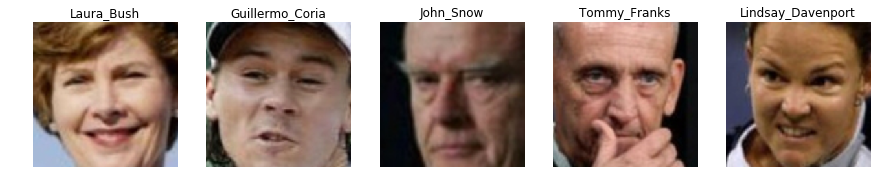

In [80]:
visualize(d, y_train)

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [20]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [21]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [23]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [37]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
class Classifier():
    def __init__(self, nn_model):
        """Your implementation"""
        self.nn_model = nn_model
        network_output = self.nn_model.get_layer('fc8').output
        self.nn_model = Model(self.nn_model.input, network_output)

    def fit(self, train_imgs, train_labels):
        """Your implementation"""
        # Create empty list of codes for each label
        unique_labels = set(train_labels.values())
        self.face_codes = {label: [] for label in unique_labels}
        
        # Preprocess images
        faces = preprocess_imgs(train_imgs.values())
        
        # Encode faces
        enc_faces = self.nn_model.predict(faces)
        
        # Iterate over encoded images
        files = list(train_imgs.keys())
        for idx in range(enc_faces.shape[0]):
            person = train_labels[files[idx]]
            self.face_codes[person].append(enc_faces[idx])
            
    def max_score_for_face_code(self, face_code):
        max_score = -1
        best_label = "unknown"
        for label, enc_faces_list in self.face_codes.items():
            score = 0
            for code in enc_faces_list:
                # Cosine similarity
                score = score + np.sum(face_code * code) / (np.linalg.norm(face_code) * 
                                                            np.linalg.norm(code))
            # Average scores
            score = score / len(enc_faces_list)
            if score > max_score:
                max_score = score
                best_label = label
                
        return best_label, max_score

    def classify_images(self, test_imgs):
        """Your implementation"""
        # Preprocess test images
        faces = preprocess_imgs(test_imgs.values())
        
        # Encode faces using existing model
        enc_faces = self.nn_model.predict(faces)
        test_enc_faces = dict(zip(test_imgs.keys(), enc_faces))
        
        # For each face check its code against all other faces
        predictions = {}
        for filename, face_code in test_enc_faces.items():
            label, max_score = self.max_score_for_face_code(face_code)
            predictions[filename] = label
        return predictions
    
    def classify_videos(self, test_video, use_n_frames = 20):
        """Your implementation"""

        predictions = {}
        for video_key, frames_list in test_video.items():
            choosen_frames_idx = [i for i in range(len(frames_list)) if i % 3 == 0]
            use_n_frames = len(choosen_frames_idx)
            choosen_frames = [frames_list[i] for i in choosen_frames_idx]
            
            # Preprocess frames to get face crops and then encode face crops
            preprocessed_frames = preprocess_imgs(choosen_frames)
            if video_key == 0:
                plt.imshow(preprocessed_frames[0])
                plt.show()
            encoded_frames = self.nn_model.predict(preprocessed_frames)
            
            # For each frame compute max cosine similarity and record for which person
            # we get the highest score
            max_scores = -np.ones((encoded_frames.shape[0]))
            max_person = ['unknown'] * max_scores.shape[0]
            assert max_scores.shape[0] == use_n_frames
            for face_code_idx, face_code in enumerate(encoded_frames):
                label, score = self.max_score_for_face_code(face_code)
                max_scores[face_code_idx] = score
                max_person[face_code_idx] = label
            
            # Find label with maximum number of occurences
            counter = Counter(max_person)
            best_label = counter.most_common(1)[0][0]
            predictions[video_key] = best_label
        return predictions

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [25]:
img_classifier = Classifier(model)
img_classifier.fit(x_train, y_train)
y_out = img_classifier.classify_images(x_test)

### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [26]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [28]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9629


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [38]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test)

/Users/minomichiang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in float_scalars


In [39]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.7857
